# Análise de Features e dos Dados em si

## Importação e Caracterização

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("interception_events.csv", index_col=0)
df.head()

,game_id,game_event_id,possession_event_type,formatted_game_clock,start_time,end_time,duration,inserted_at,updated_at,start_frame,...,21_vy,21_vtot,21_ax,21_ay,21_atot,home_ball,ball_visibility,ball_x,ball_y,ball_z
0,4438,4435777,PA,00:00,148.300,148.300,0.0,2022-08-06 17:07:20,2022-08-07 01:31:28,4389,...,-0.75,1.060660,0.000000e+00,0.000000e+00,0.000000e+00,0.0,ESTIMATED,-2.135,1.725,0.30
1,4438,4435792,PA,00:02,151.233,151.233,0.0,2022-08-06 17:08:25,2022-08-07 01:31:28,4477,...,-0.33,0.632851,-1.598721e-12,-9.000000e-01,9.000000e-01,0.0,VISIBLE,-21.122,3.604,0.00
2,4438,4435795,PA,00:07,155.667,155.667,0.0,2022-08-06 17:08:39,2022-08-07 01:31:28,4610,...,-1.92,3.003748,1.800000e+00,0.000000e+00,1.800000e+00,0.0,VISIBLE,-8.428,-27.775,0.58
3,4438,4435805,PA,00:19,167.633,167.633,0.0,2022-08-06 17:09:04,2022-08-07 01:31:28,4969,...,0.39,0.926121,1.800000e+00,-7.993606e-13,1.800000e+00,1.0,ESTIMATED,48.219,1.006,0.82
4,4438,4435817,PA,00:21,170.033,170.033,0.0,2022-08-06 17:09:34,2022-08-07 01:31:28,5041,...,0.45,1.114854,1.598721e-12,0.000000e+00,1.598721e-12,1.0,VISIBLE,46.345,-12.923,0.00


In [14]:
print(f"Número de jogos contemplados: {len(df['game_id'].unique())}")
print(f"Número de passes: {len(df)}")
print(f"Número de interceptações: {df['pass_outcome_type'].value_counts()['D']}")
print(f"Número de passes completos: {df['pass_outcome_type'].value_counts()['C']}")
print(f"Razão de interceptações por passe completo: {df['pass_outcome_type'].value_counts()['D'] / df['pass_outcome_type'].value_counts()['C']}")

Número de jogos contemplados: 23
Número de passes: 19646
Número de interceptações: 2633
Número de passes completos: 16225
Razão de interceptações por passe completo: 0.1622804314329738


In [29]:
# pressure_type não é dado normalmente, então excluímos - voronoi da para nos essa info
pass_features = ["pass_body_type", "pass_high_point_type", "pass_type", "pressure_type", "passer_preferred_foot_player", "target_player"]

In [30]:
print("Informações nulas no DF")
for f in pass_features:
    print(f + ": " + str(sum(df[f].isna())))

Informações nulas no DF
pass_body_type: 0
pass_high_point_type: 0
pass_type: 1
pressure_type: 15888
passer_preferred_foot_player: 1491
target_player: 7


In [26]:
# Quando não tem o pé preferido do jogador, foi de cabeça ou outra parte do corpo?
# Não necessariamente, então atributo fraco para a gente
df[df["passer_preferred_foot_player"].isna()]["pass_body_type"].value_counts()

pass_body_type
R           961
L           276
TWOHANDS    101
HE           92
VM           34
RB           14
CH            7
RH            4
RK            1
RT            1
Name: count, dtype: int64

In [40]:
not_na_features = ["pass_outcome_type", "pass_body_type", "pass_high_point_type", "pass_type", "target_player"]

df_sel = df.dropna(subset=not_na_features)

print(f"Instâncias agora: {len(df_sel)}")
print(f"Instâncias antes: {len(df)}")

Instâncias agora: 19638
Instâncias antes: 19646


## Análise

In [42]:
pass_features = ['pass_body_type', 'pass_high_point_type', 'pass_type']

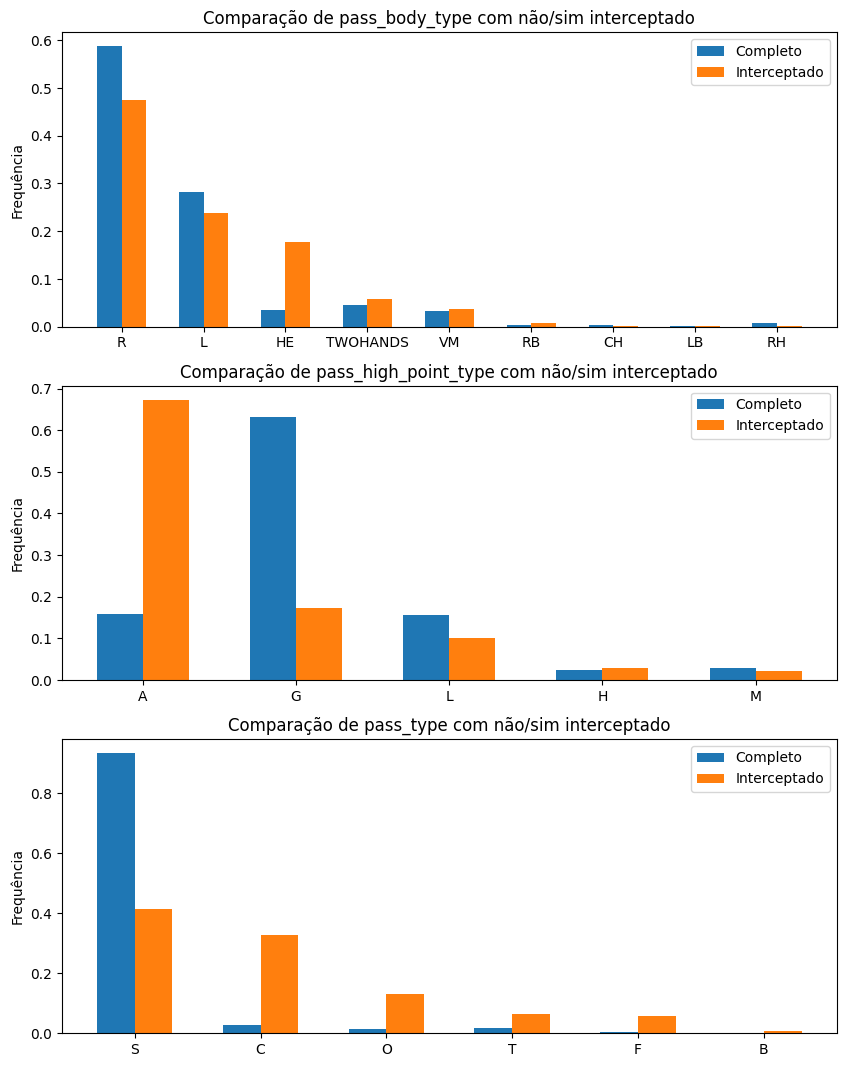

In [86]:
fig, ax = plt.subplots(3, 1, figsize=(10, 13))
for i, f in enumerate(pass_features):
    interception_filter = df_sel["pass_outcome_type"] == "D"
    
    counts0 = df_sel.loc[~interception_filter, f].value_counts()
    counts1 = df_sel.loc[interception_filter, f].value_counts()
    
    counts0 /= counts0.sum()
    counts1 /= counts1.sum()
    
    counts1 = counts1[counts1.values > 0.001]
    
    counts0 = counts0[counts1.index]
    
    idx = np.arange(len(counts0))
    
    width = 0.3
    
    ax[i].bar(idx, counts0.values, width, label="Completo")
    ax[i].bar(idx+width, counts1.values, width, label="Interceptado")
    
    ax[i].set_ylabel('Frequência')
    ax[i].set_title(f'Comparação de {f} com não/sim interceptado')
    ax[i].set_xticks(idx + width / 2)
    ax[i].set_xticklabels(counts1.index)
    ax[i].legend()
plt.show()

## BoxPlot do Voronoi

## Classificador Dummy por posição

Objetivo aqui é construir uma matriz de bins que determina se o transmissor está no quadrante i e o receptor no quadrante j, então calcule a chance de interceptação

In [149]:
# Selecionando qual jogador deu o passe (posição da bola man) e qual vai receber

players_id = [f"{i}_player_id" for i in range(22)]

def return_position_of_receptor_and_ball(row):
    for c in players_id:
        if row[c] == row["target_player"]:
            i = c.split("_")[0]
            return (row["pass_outcome_type"] == 'D', row["ball_x"], row["ball_y"], row[f"{i}_x"], row[f"{i}_y"]) 
    return np.nan


receps = [return_position_of_receptor_and_ball(row) for i, row in df_sel.iterrows() if not np.isnan(return_position_of_receptor_and_ball(row)).any()]

In [150]:
receps = np.array(receps)
label, ball_x, ball_y, recep_x, recep_y = receps[:, 0], receps[:, 1], receps[:, 2], receps[:, 3], receps[:, 4]

ball_x += 52.5
recep_x += 52.5
ball_y += 34
recep_y += 34

N = 30

In [163]:
def return_grid_position(x, y):
    interval_x = 105 / N
    interval_y = 68 / N

    return int(min(N-1, max(x // interval_x, 0))), int(min(N-1, max(y // interval_y, 0)))

In [164]:
interceps = np.zeros((N*N, N*N))
not_interceps = np.zeros((N*N, N*N))

for i in range(len(label)):
    bx, by = return_grid_position(ball_x[i], ball_y[i])
    rx, ry = return_grid_position(recep_x[i], recep_y[i])
    
    if label[i]:
        interceps[bx*N + by, rx*N + ry] += 1
    else:
        not_interceps[bx*N + by, rx*N + ry] += 1

In [171]:
m = interceps / (interceps + not_interceps)

C:\Users\tonim\AppData\Local\Temp\ipykernel_10568\2083698203.py:1: RuntimeWarning: invalid value encountered in divide
  m = interceps / (interceps + not_interceps)
